In [1]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
player_ratings = pd.read_csv('.\data\player_ratings.csv')
player_ratings.describe()

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
count,8.342260e+05,8.342260e+05,8.342260e+05,834226.000000,834226.000000
mean,-9.225868e+07,5.479852e+00,1.095979e+01,25.112577,7.270275
std,8.103222e+07,1.760984e+03,3.629559e+03,3.231603,1.128826
min,-2.991940e+08,0.000000e+00,1.000000e+00,4.993478,1.404098
25%,-1.499249e+08,0.000000e+00,1.000000e+00,22.906655,6.957458
50%,-9.585022e+07,1.000000e+00,2.000000e+00,25.018193,7.732504
75%,4.883475e+04,3.000000e+00,6.000000e+00,27.240350,8.058739
max,3.305130e+05,1.608398e+06,3.315071e+06,48.825892,8.333689


Player rating is based on trueskill_mu, which is the skill, where the higher the rating value the better. The trueskill_sigma is the uncertainty of the rating. Calculated the ratings on 900k mathces which occured prior to other uploaded datasets on kaggle.

In [3]:
player_ratings['trueskill_mu'].describe()

count    834226.000000
mean         25.112577
std           3.231603
min           4.993478
25%          22.906655
50%          25.018193
75%          27.240350
max          48.825892
Name: trueskill_mu, dtype: float64

The players skill level in this data set ranges from 4.99 to 48.8, with the mean skill level of 25

In [4]:
bins = [0, 22.9,27.24,50]
labels = [0,1,2]
player_ratings['skill_labels'] = pd.cut(player_ratings['trueskill_mu'], bins = bins, include_lowest=False, right = True,labels = labels) 

wins_skill = player_ratings.drop(['account_id','trueskill_sigma'],axis=1)
wins_skill['win_rate'] = (wins_skill['total_wins'] / wins_skill['total_matches'])
wins_skill.head()

,total_wins,total_matches,trueskill_mu,skill_labels,win_rate
0,14,24,27.868035,2,0.583333
1,1,1,26.544163,1,1.000000
2,1,1,26.521103,1,1.000000
3,1,1,27.248025,2,1.000000
4,0,1,22.931016,1,0.000000


Text(0.5, 1.0, 'Wins vs Skill Level')

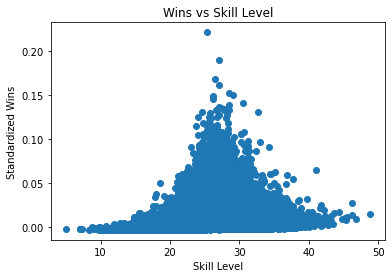

In [5]:
scaler = StandardScaler()
data = scaler.fit(wins_skill[['total_wins', 'total_matches']])
data = scaler.transform(wins_skill[['total_wins', 'total_matches']])
data = pd.DataFrame(data=data, columns = (['total_wins','total_matches']))
data = data.assign(trueskill_mu = wins_skill['trueskill_mu'], skill_labels = wins_skill['skill_labels'], win_rate = wins_skill['win_rate'])
#Removing outlier that threw off the scale of the graph
data.drop(data[data['total_wins'] > 800].index, inplace=True)

plt.scatter(x = data['trueskill_mu'], y = data['total_wins'])
plt.ylabel("Standardized Wins")
plt.xlabel("Skill Level")
plt.title("Wins vs Skill Level")

Text(0.5, 1.0, 'Total Matches vs Skill Level')

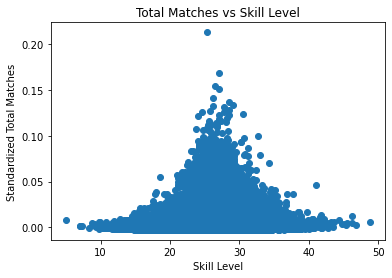

In [36]:
#Total matches versus skill level
plt.scatter(x = data['trueskill_mu'], y = data['total_matches'])
plt.ylabel("Standardized Total Matches")
plt.xlabel("Skill Level")
plt.title("Total Matches vs Skill Level")

Text(0.5, 1.0, 'Win Rate vs Skill Level')

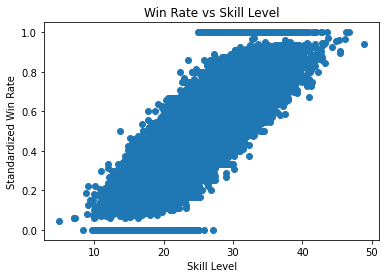

In [6]:
#Win rate versus skill level
plt.scatter(x = data['trueskill_mu'], y = data['win_rate'])
plt.ylabel("Standardized Win Rate")
plt.xlabel("Skill Level")
plt.title("Win Rate vs Skill Level")

As we can see the win rate is positively linearly correlated with the skill level. By using the total wins and total matches played, we might be able to predict/classify the skill level of a player

In [7]:
#Training a kNN model with training and testing data
X = data[['total_wins', 'total_matches']]
y = data['skill_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
score = knn.score(X_test, y_test)
print(score)

0.6769097066139231


C:\Users\ruzzo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


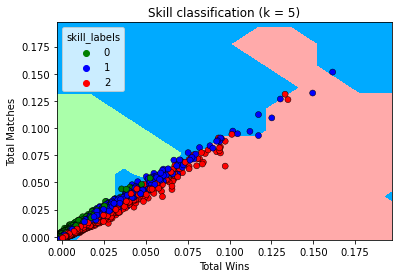

In [91]:
from matplotlib.colors import ListedColormap
# Create color maps
cmap_light = ListedColormap(['#AAFFAA','#00AAFF','#FFAAAA'])
cmap_bold = ['g','b','r']

# calculate min, max and limits
x_min, x_max = X.iloc[:, 0].min(), X.iloc[:, 0].max() -0.01
y_min, y_max = X.iloc[:, 1].min(), X.iloc[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
np.arange(y_min, y_max, 0.02))

# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=cmap_light)

scatter = sbn.scatterplot(X_test.iloc[:, 0], X_test.iloc[:, 1], hue = y_test, palette=cmap_bold, alpha = 1.0, edgecolor='black')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Skill classification (k = 5)")
plt.xlabel('Total Wins')
plt.ylabel('Total Matches')
plt.show()

The green labels/area represents begginer skill level (bottom quartile), blue represents intermediate, and red represents pro. It appears that beginners dont play that many matches or win many games. Whereas the pro skill level tend to win a higher percentage of games compared ot the other two levels.